# NB6 Status

## Import

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.lines as mlines

## File path

In [2]:
filepath="/home/lwang/data/Nbody/debug/16kb/status.36"
fse=True

## Functions

In [3]:
def dict_tree(names,data):
    if (len(names)>1):
        nk = len(names[0])
        if (len(data.shape) < 2): raise Exception("Input data is not two-dimensional array.")
        if (data.shape[0]%nk > 0): 
            raise Exception("Input data columns size %i and names size %i unmatched" %(data.shape[0],nk))
        ncols = data.shape[0]/nk
        dtemp = collections.OrderedDict() 
        for i in range(nk): dtemp[names[0][i]]=dict_tree(names[1:],data[i*ncols:(i+1)*ncols])
        return dtemp
    else:
        nk = len(names[0])
        if (nk!=data.shape[0]): raise Exception("The inner most name size %i and data columns %i unmatched" %(nk,data[0].size))
        dtemp = collections.OrderedDict() 
        for i in range(nk): dtemp[names[0][i]]=data[i] 
        return dtemp

In [4]:
def status(path,seflag):
    data = np.transpose(np.loadtxt(path))
    dtemp = collections.OrderedDict()

    ifoff = 16
    dtemp['t']    = dict_tree((('NB','Myr'),),data[0:2].astype('f'))    # Time in NB unit and Myr
    dtemp['tcr']  = data[2].astype('f')                                 # crossing time in Myr
    dtemp['trh']  = data[3].astype('f')                                 # half-mass relaxation time in Myr
    dtemp['mass'] = dict_tree((('T','S','B'),),data[4:7].astype('f'))   # total, single, binary mass in M_sun
    dtemp['q']    = data[7].astype('f')                                 # Virial ration
    dtemp['rh']   = data[8].astype('f')                                 # half-mass radius in pc
    dtemp['rt']   = data[9].astype('f')                                 # tidal radius in pc
    dtemp['rden'] = dict_tree((('x','y','z'),),data[10:13].astype('f')) # Density center position
    dtemp['rhod'] = data[13].astype('f')                                # Density weighted average density ΣRHO2/ΣRHO 
    dtemp['rhom'] = data[14].astype('f')                                # Maximum mass density / half mass mean value
    dtemp['mmax'] = data[15].astype('f')                                # Maxium stellar mass

    ieoff = 12 + ifoff
    dtemp['energy'] = dict_tree( (('Etot','Ekin','Epot','Ebin','Etid','Em','Ecol','Ece','Ekick','Eesc','Ebesc','Emesc'),), 
                                data[ifoff:ieoff].astype('f') )         # Energy parameters
    
    inoff = 5 + ieoff
    # Number of stars Total(resolved),Single,Binary,Triple,Total(unresolved)
    dtemp['n']    = dict_tree((('T','S','B','M','Tu'),), data[ieoff:inoff].astype('i'))     
    
    iloff = 486 + inoff
    ffrac=('0.1%','1%','10%','30%','50%','70%','90%','100%','Rc')
    ffracn=('0.1%','1%','10%','30%','50%','70%','90%','100%')
    lpars=('r','n','m','v','vx','vy','vz','vr','vt','vrot','s','sx','sy','sz','sr','st','srot','e')
    # Lagrangian radii (total, single, binary) 
    dtemp['lagr'] = dict_tree( (('T','S','B'),lpars,ffrac), data[inoff:iloff].astype('f') )         
    
    ibfoff = 16 + iloff
    # binary mass in global lagr
    dtemp['binary'] = dict_tree( (('m',),ffracn), data[iloff:iloff+8].astype('f') )
    # binary number in global lagr
    dtemp['binary'].update(dict_tree( (('n',),ffracn), data[iloff+8:ibfoff].astype('i')) )     

    ipbfoff = 18 + ibfoff
    # primordinary binary mass in global lagr
    dtemp['pbinary'] = dict_tree( (('m',),ffrac), data[ibfoff:ibfoff+9].astype('f') )
    # primordinary binary number in global lagr
    dtemp['pbinary'].update(dict_tree( (('n',),ffrac), data[ibfoff+9:ipbfoff].astype('i')) )

    iebfoff = 17 + ipbfoff
    # binary binding energy in global lagr (negative)
    dtemp['binary'].update(dict_tree( (('Ebin',),ffrac), data[ipbfoff:ipbfoff+9].astype('f') ))  
    # binary binding energy in binary lagr (negative)
    dtemp['binary'].update(dict_tree( (('Ebinb',),ffracn), data[ipbfoff+9:iebfoff].astype('f') ))

    iepbfoff = 17 + iebfoff
    # binary binding energy in global lagr (negative)
    dtemp['pbinary'].update(dict_tree( (('Ebin',),ffrac), data[iebfoff:iebfoff+9].astype('f') ))
    # binary binding energy in binary lagr (negative)
    dtemp['pbinary'].update(dict_tree( (('Ebinb',),ffracn), data[iebfoff+9:iepbfoff].astype('f') ))
                                     
    iaoff = 27 + iepbfoff
    # Angular momentum in global lagr
    dtemp['A'] = dict_tree( (('x','y','z'),ffrac), data[iepbfoff:iaoff].astype('f') )

    if (seflag):
        isfoff = 58 + iaoff
        # stellar mass loss
        dtemp['mass'].update(dict_tree( (('SE',),('dM',)), data[iaoff:iaoff+1].astype('f') ))            
        # New stellar mass (red giant, helium star, red supergiant, naked helium star, white dwarf, neutron star)
        dtemp['mass']['SE'].update(dict_tree( (('New',),('RG','He','RSG','NHe','WD','SN')), data[iaoff+1:iaoff+7].astype('f') ))  
        # Current stellar mass from KZ type -1 to 15
        dtemp['mass']['SE'].update(dict_tree( (('Current',),
                                               ('PMS','LMS','HMS','HG','RG','CHB','FAGB','SAGB',
                                                'HeMS','HeHG','HeGB','HeWD','COWD','ONWD','NS','BH','SNR'),
                                               ('S','B','BB')), data[iaoff+7:isfoff].astype('f') ))          

        isnoff = 72 + isfoff
        # event counts
        #  1. NDISS: Tidal dissipation at pericenter (#27 >0)
        #  2. NTIDE: Tidal captures (#27 >0)
        #  3. NSYNC: Synchronous binaries (#27 >0)
        #  4. NCOLL: stellar collision
        #  5. NCOAL: stellar coalescence
        #  6. NCIRC: circularized binaries (#27 >0)
        #  7. NROCHE: Roche stage triggered times
        #  8. NRO: Roche binary events
        #  9. NCE: Common envelope binaries
        # 10. NHYP: Hyperbolic collision
        # 11. NHYPC: Hyperbolic common envelope binaries
        # 12. NKICK: WD/NS/BH kick
        # 13. NMDOT: Stellar mass loss event
        dtemp['n'].update(dict_tree( (('SE',),('Events',),('Diss','Tid','Syn','Coll','Coal','Circ',
                                                           'Roche','RoBin','CE','Hcoll','HCE','Kick','dM')), 
                                    data[isfoff:isfoff+13].astype('i') ))
        # New stellar types
        # 14. NRG: New red giants
        # 15. NHE: New helium stars
        # 16. NRS: New red supergiants
        # 17. NNH: New naked helium stars
        # 18. NWD: New white dwarfs
        # 19. NSN: New neutron stars
        # 20. NBH: New black holes
        # 21. NBS: New blue stragglers
        dtemp['n']['SE'].update(dict_tree( (('New',),('RG','He','RSG','NHe','WD','NS','BH','BS')), 
                                          data[isfoff+13:isfoff+21].astype('i') ))
        # Current stellar number from KZ type -1 to 15
        dtemp['n']['SE'].update(dict_tree( (('Current',),
                                            ('PMS','LMS','HMS','HG','RG','CHB','FAGB','SAGB',
                                             'HeMS','HeHG','HeGB','HeWD','COWD','ONWD','NS','BH','SNR'),
                                            ('S','B','BB')), data[isfoff+21:isnoff].astype('i') ))

        isloff = 1782 + isnoff
        # lagraigan radii parameters for stellar types
        # 1.  Low mass main sequence (M < 0.7) (0)
        # 2.  High mass main sequence  (1)
        # 3.  Hertzsprung gap (HG). (2)
        # 4.  Red giant. (3)
        # 5.  Core Helium burning. (HB) (4)
        # 6.  AGB (5-6)
        # 7.  Helium types (7-9)
        # 8.  White dwarf (10-12)
        # 9.  Neutron star (13)
        # 10. Black hole (14)
        # 11. Pre main sequence (-1)
        dtemp['lagr'].update(dict_tree( (('SE',),('LMS','HMS','HG','RG','CHB','AGB','He','WD','NS','BH','PMS'),
                                         lpars,ffrac), data[isnoff:isloff].astype('f') ))
        
        return dtemp

In [5]:
def dict_tree_show(data):
    def dict_tree_show_loop(data,n):
        if (type(data)!=collections.OrderedDict):
                if (type(data)==np.ndarray): print '    '*(n+1),type(data), data.shape, data.dtype
                else: print type(data)
        else:
            n += 1
            for i in data.keys():
                print '    '*n,'--',i
                dict_tree_show_loop(data[i],n)
    dict_tree_show_loop(data,-1)

## Load data

In [6]:
data=status(filepath,fse)

In [7]:
dict_tree_show(data)

 -- t
     -- NB
         <type 'numpy.ndarray'> (352,) float32
     -- Myr
         <type 'numpy.ndarray'> (352,) float32
 -- tcr
     <type 'numpy.ndarray'> (352,) float32
 -- trh
     <type 'numpy.ndarray'> (352,) float32
 -- mass
     -- T
         <type 'numpy.ndarray'> (352,) float32
     -- S
         <type 'numpy.ndarray'> (352,) float32
     -- B
         <type 'numpy.ndarray'> (352,) float32
     -- SE
         -- dM
             <type 'numpy.ndarray'> (352,) float32
         -- New
             -- RG
                 <type 'numpy.ndarray'> (352,) float32
             -- He
                 <type 'numpy.ndarray'> (352,) float32
             -- RSG
                 <type 'numpy.ndarray'> (352,) float32
             -- NHe
                 <type 'numpy.ndarray'> (352,) float32
             -- WD
                 <type 'numpy.ndarray'> (352,) float32
             -- SN
                 <type 'numpy.ndarray'> (352,) float32
         -- Current
             -- PMS
                

## Plot

## color

In [8]:
##        Black      Blue       Cyan      Green      Lime       Olive      Red       Maroon      Magenta    Purple    
colors=('#000000', '#0000FF', '#00FFFF', '#008000', '#00FF00', '#808000', '#FF0000', '#800000', '#FF00FF', '#800080' ,
        '#0000A0', '#ADD8E6', '#FFFF00', '#FFA500', '#A52A2A', '#808080', '#C0C0C0')
##        darkblue  lightblue   yellow    orange      brown      grey      silver
markers=("o", "v", "^", "<", ">", "1", "2", "3", "4", "*", "s")
linetypes=('-','--','-.',':')

### Mass & N

T/S/B
NEW
Current

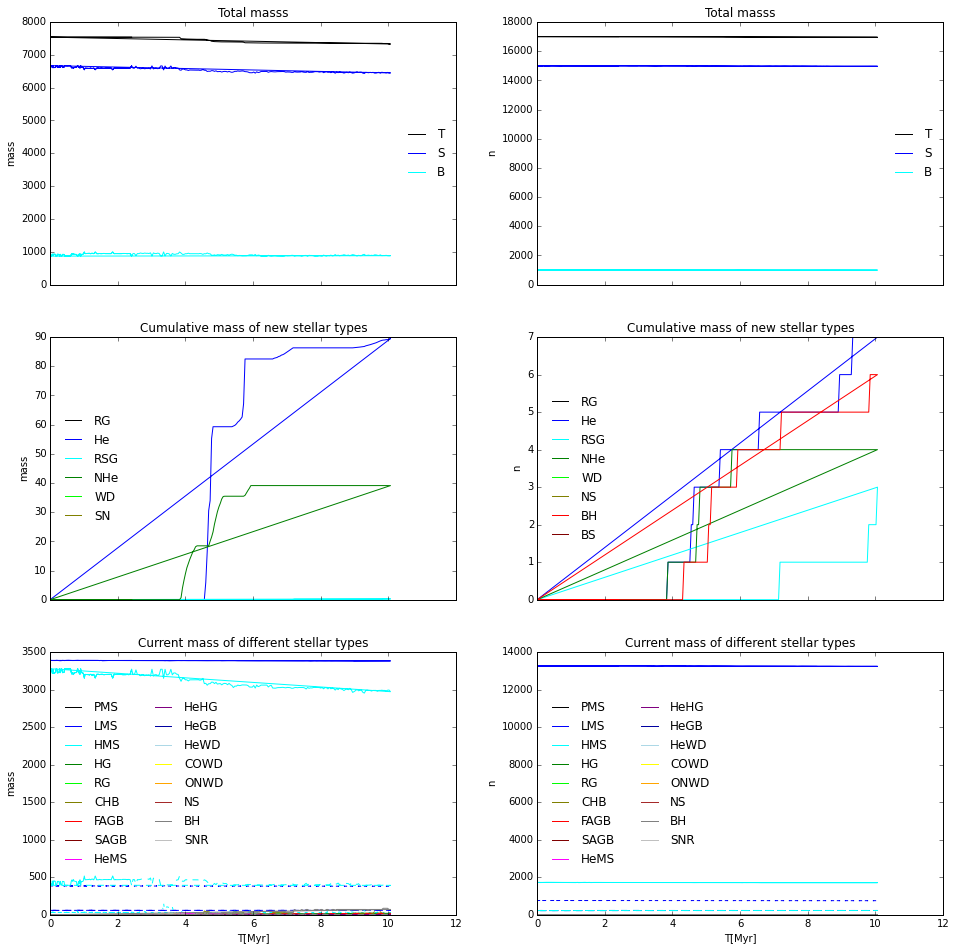

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2,sharex=True)

#size of image
figcf = plt.gcf()
figcf.set_size_inches(16,16)
#plt.subplots_adjust(hspace=0)

groups=('mass','n')
l0 = ('T','S','B')

x = data['t']['Myr']

for k in range(len(groups)):
    gkey = groups[k]
    axes[0][k].set_ylabel(gkey)
    axes[0][k].set_title('Total masss')
    nd = data[gkey]
    for i in range(len(l0)):
        key = l0[i]
        axes[0][k].plot(x,nd[key],'-',color=colors[i],label=key)
    axes[0][k].legend(loc='center right',frameon=False)
    
    axes[1][k].set_title('Cumulative mass of new stellar types')
    axes[1][k].set_ylabel(gkey)
    nd = data[gkey]['SE']['New']
    for i in range(len(nd.keys())):
        key = nd.keys()[i]
        axes[1][k].plot(x,nd[key],'-',color=colors[i],label=key)
    axes[1][k].legend(loc='center left',frameon=False)
    
    patchs=[]
    axes[2][k].set_title('Current mass of different stellar types')
    axes[2][k].set_ylabel(gkey)
    axes[2][k].set_xlabel('T[Myr]')
    nd = data[gkey]['SE']['Current']
    for i in range(len(nd.keys())):
        key = nd.keys()[i]
        nn = 0
        for n in nd[key].keys():
            axes[2][k].plot(x,nd[key][n],linetypes[nn],color=colors[i])
            if (nn==0): 
                patch = mlines.Line2D([],[],linestyle=linetypes[nn],color=colors[i],label=key)
                patchs.append(patch)
            nn += 1
    axes[2][k].legend(handles=patchs,ncol=2,loc='center left',frameon=False)

### Virial ratio

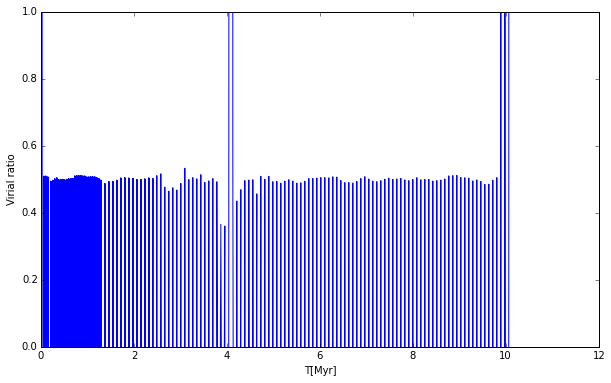

In [10]:
fig = plt.figure(figsize=(10,6))

plt.ylim(0,1)
plt.xlabel('T[Myr]')
plt.ylabel('Virial ratio')
plt.plot(data['t']['Myr'],data['q'],'-')

### Energy

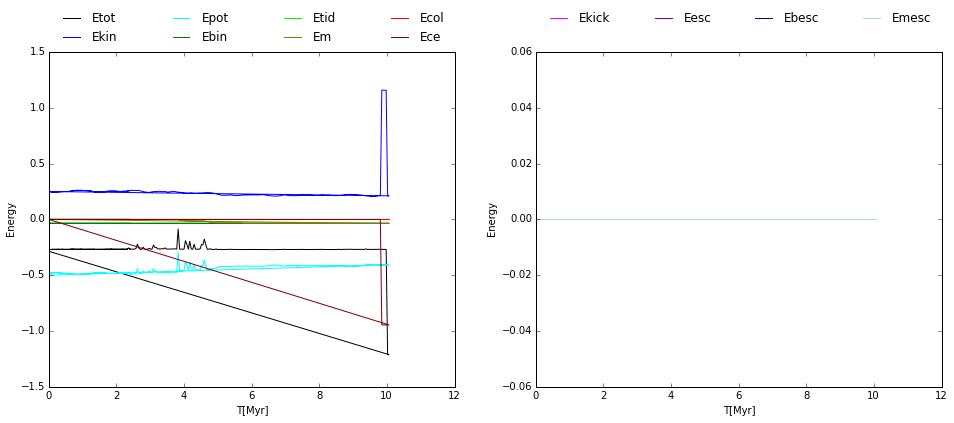

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True)

#size of image
figcf = plt.gcf()
figcf.set_size_inches(16,6)

axes[0].set_xlabel('T[Myr]')
axes[0].set_ylabel('Energy')
for i in range(8):
    key = data['energy'].keys()[i]
    axes[0].plot(data['t']['Myr'],data['energy'][key],'-',color=colors[i],label=key)
axes[0].legend(mode='expand',bbox_to_anchor=(0, 1.05, 1.0, .102),ncol=4, frameon=False)

axes[1].set_xlabel('T[Myr]')
axes[1].set_ylabel('Energy')
for i in range(8,12):
    key = data['energy'].keys()[i]
    axes[1].plot(data['t']['Myr'],data['energy'][key],'-',color=colors[i],label=key)
axes[1].legend(mode='expand',bbox_to_anchor=(0, 1.05, 1.0, .102),ncol=4, frameon=False)


### Events count

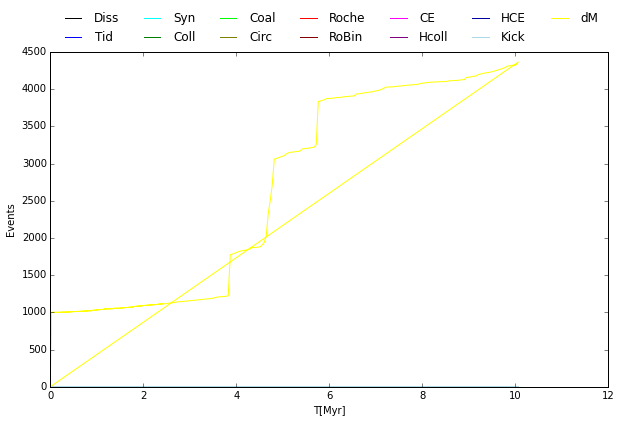

In [12]:
fig = plt.figure(figsize=(10,6))

plt.xlabel('T[Myr]')
plt.ylabel('Events')
gdat = data['n']['SE']['Events']
k=0
for i in gdat.keys():
    plt.plot(data['t']['Myr'],gdat[i],'-',color=colors[k],label=i)
    k += 1
plt.legend(mode='expand',bbox_to_anchor=(0, 1.05, 1.0, .102),ncol=7, frameon=False)

### Lagragian

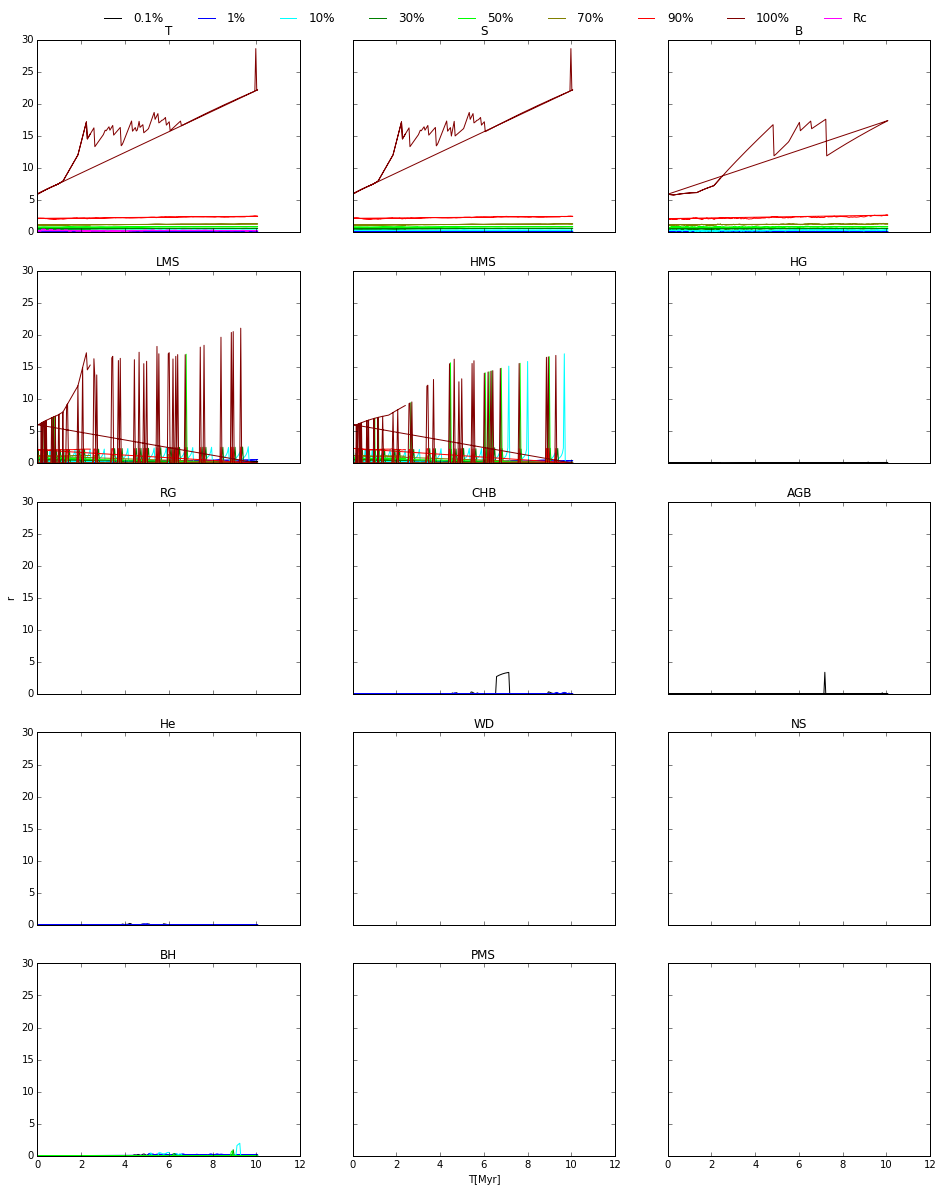

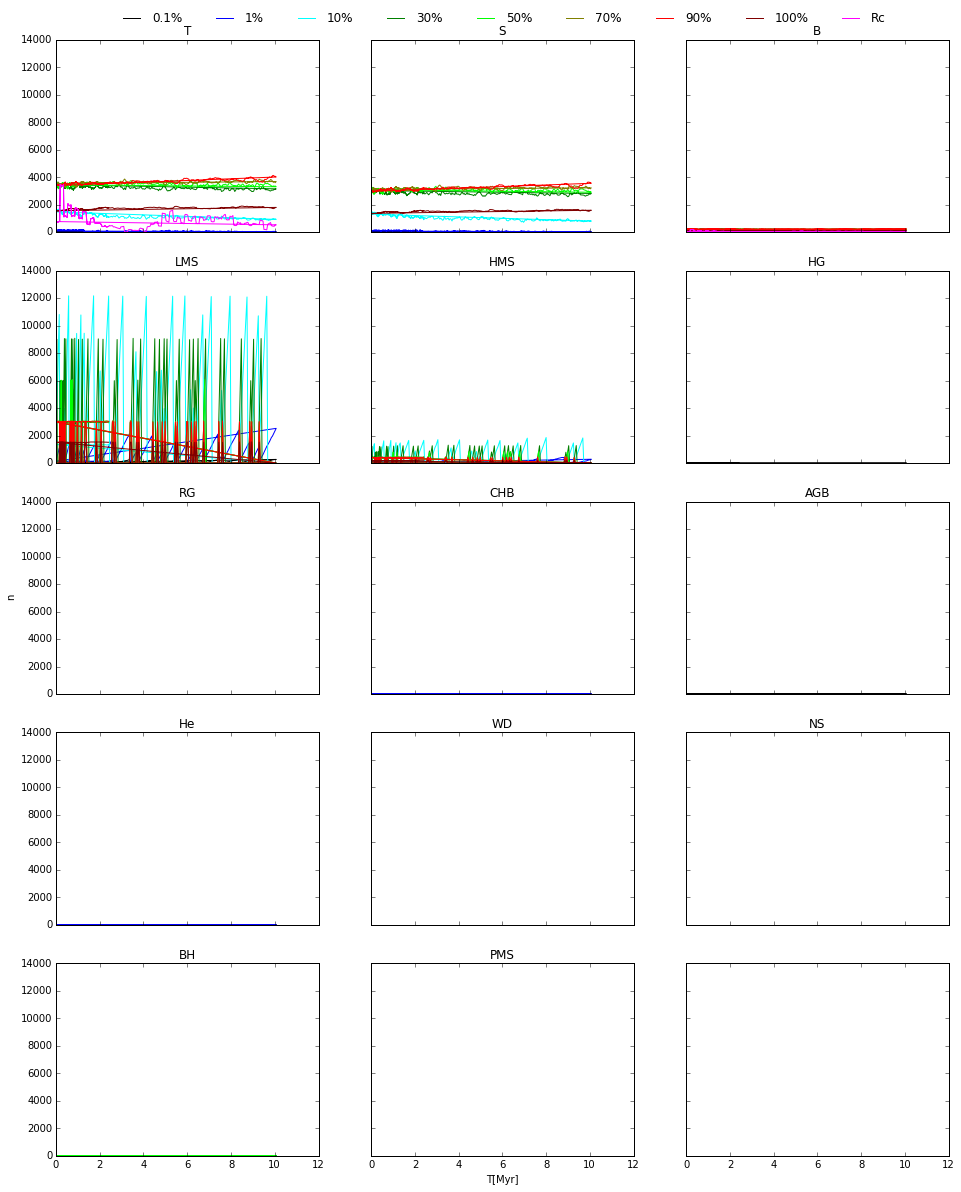

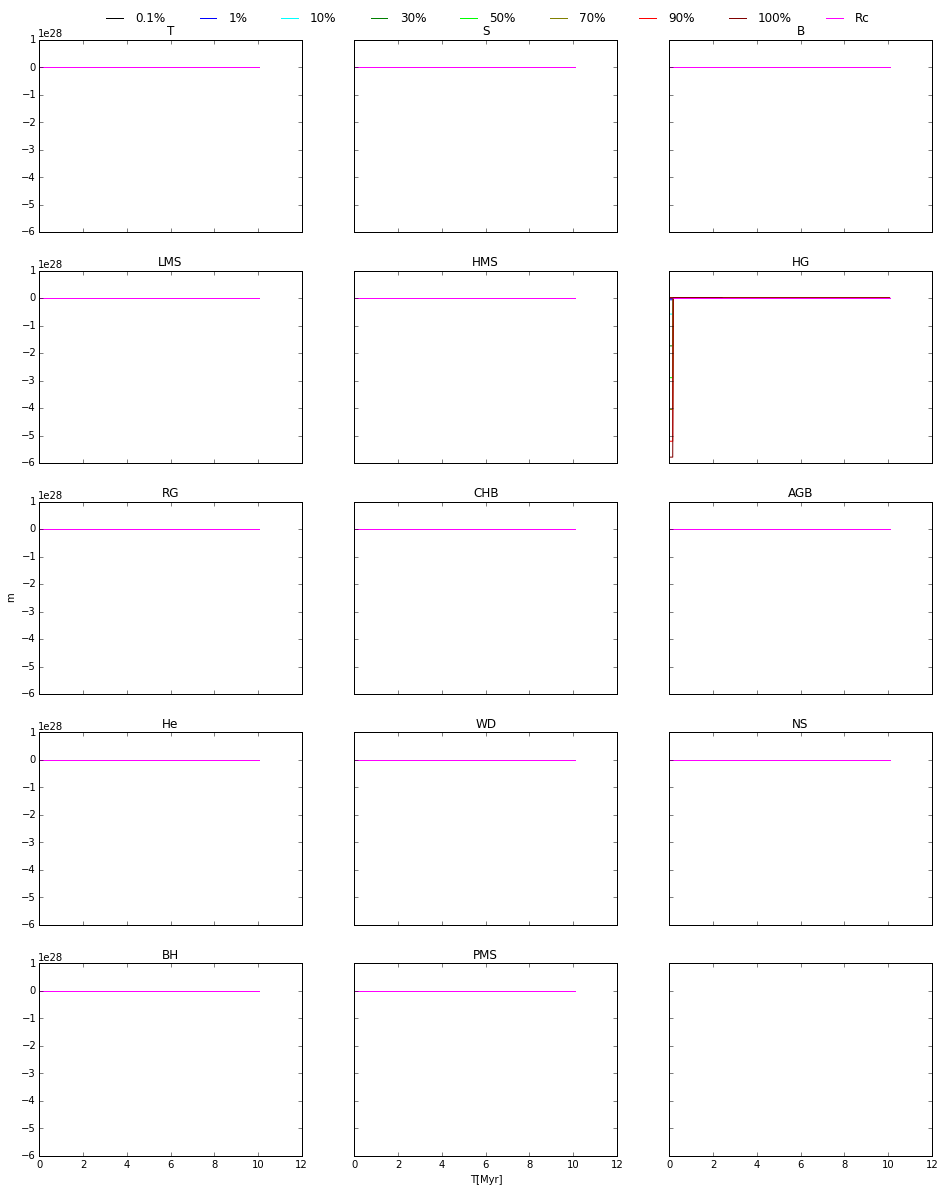

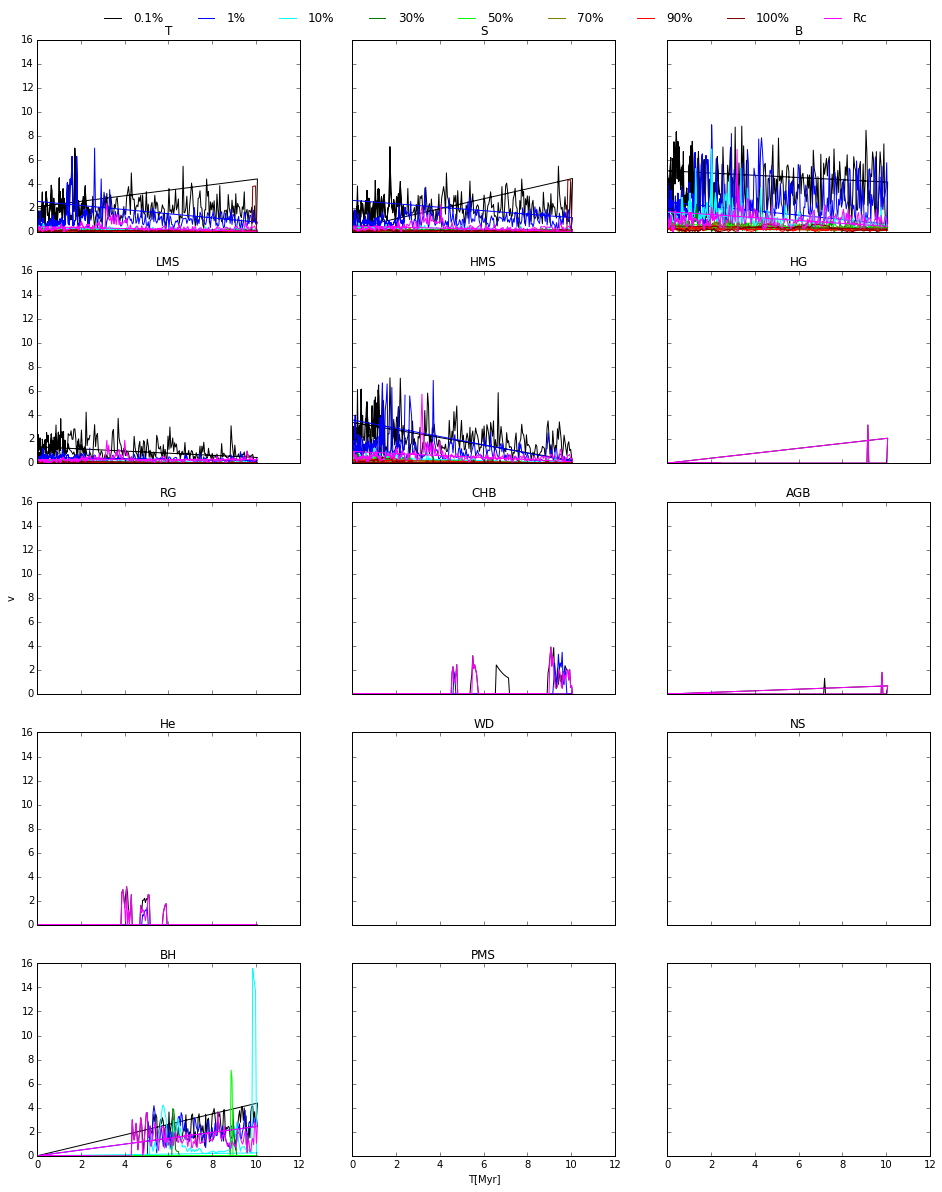

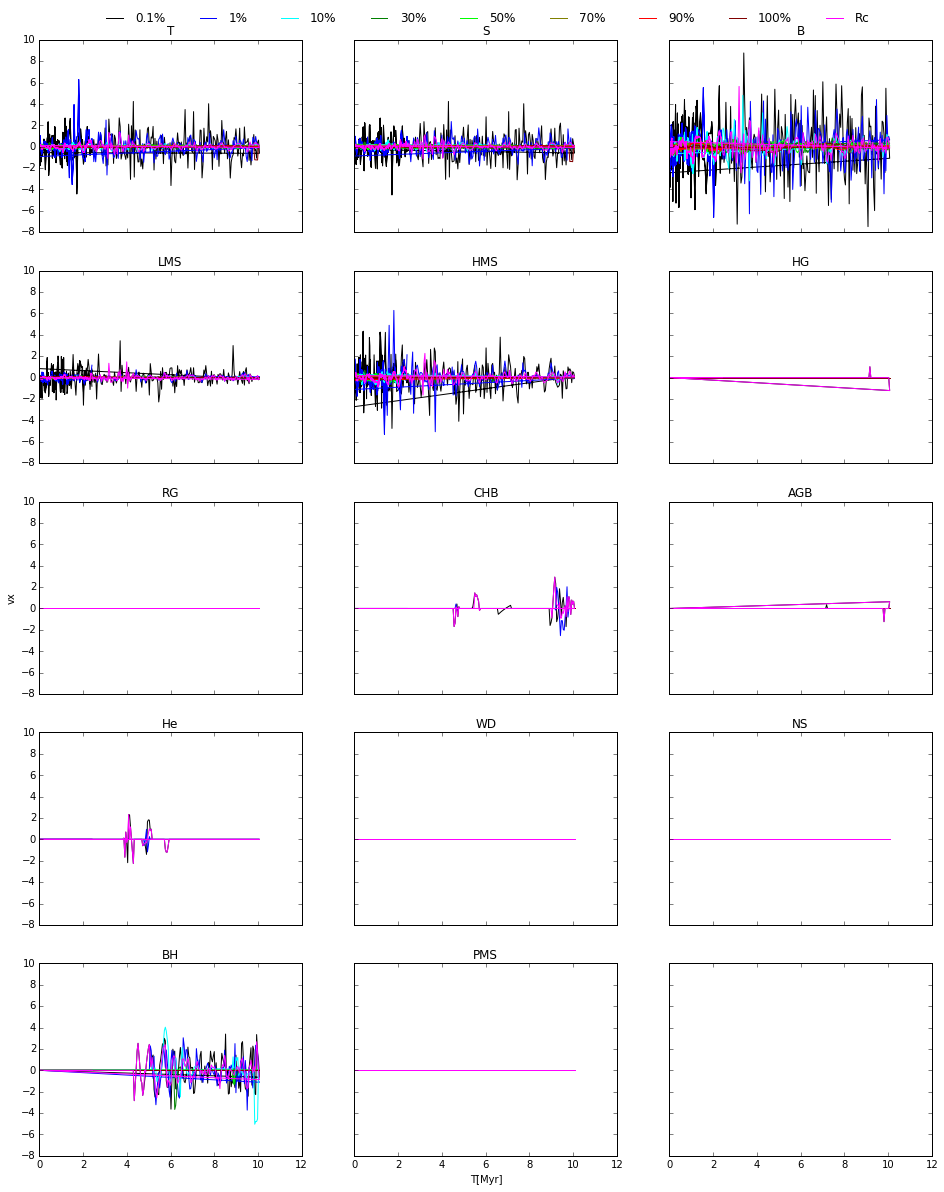

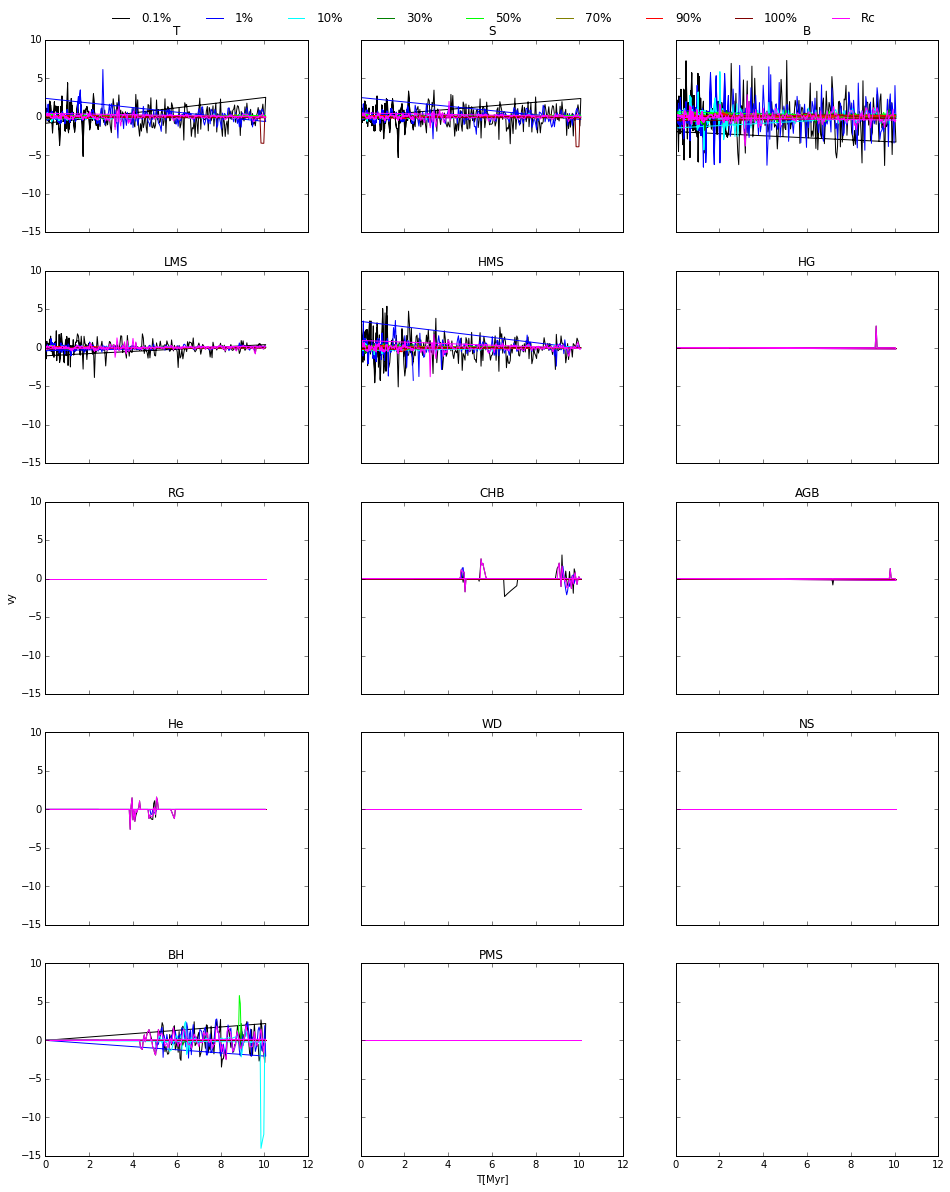

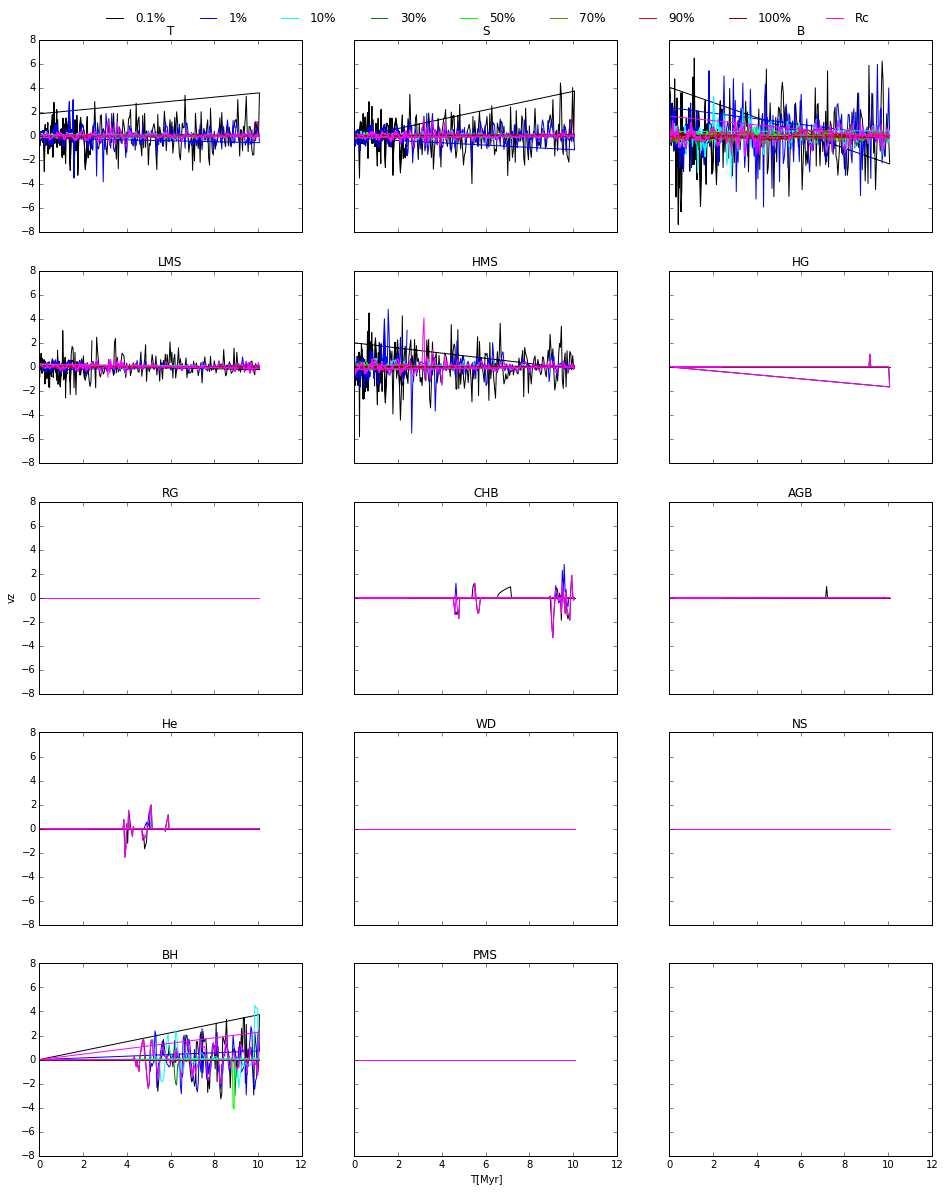

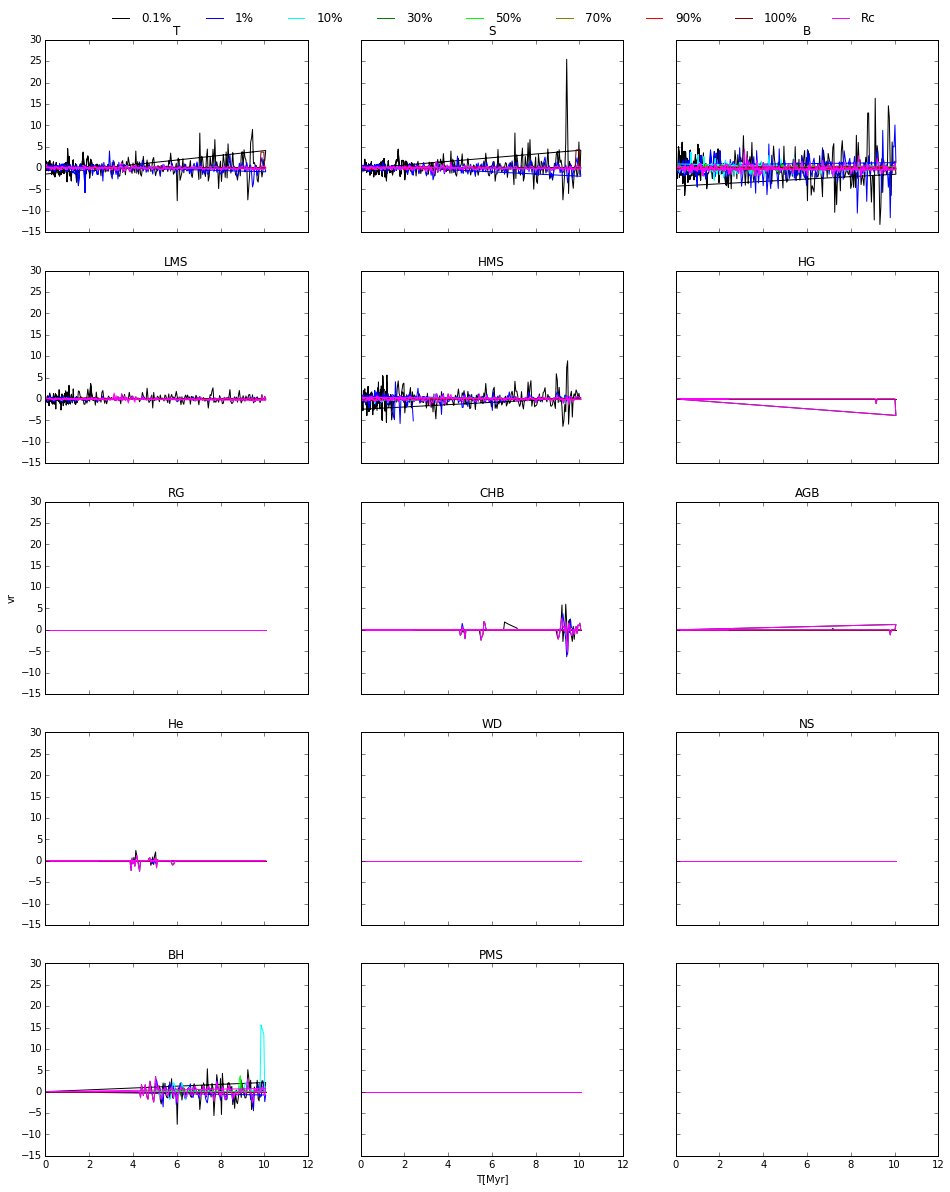

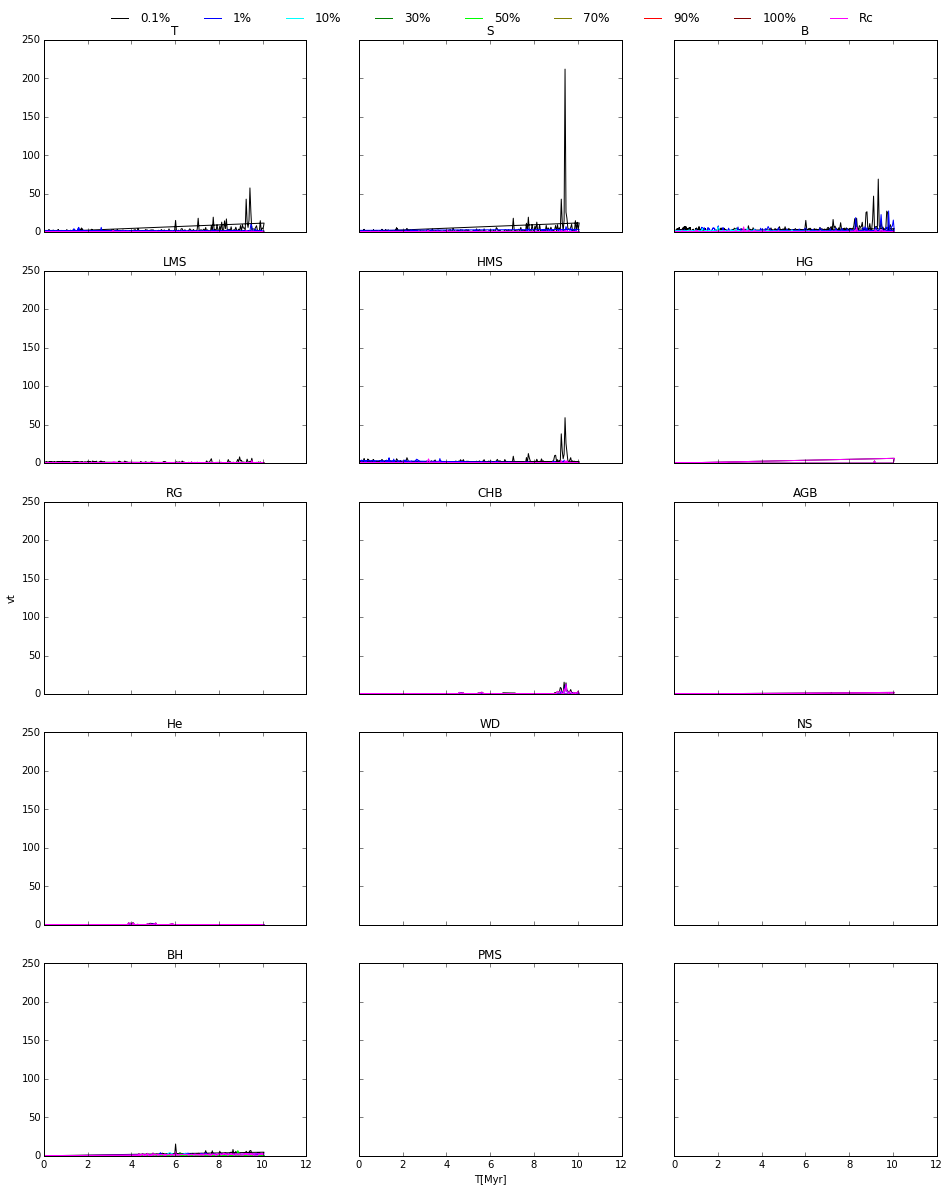

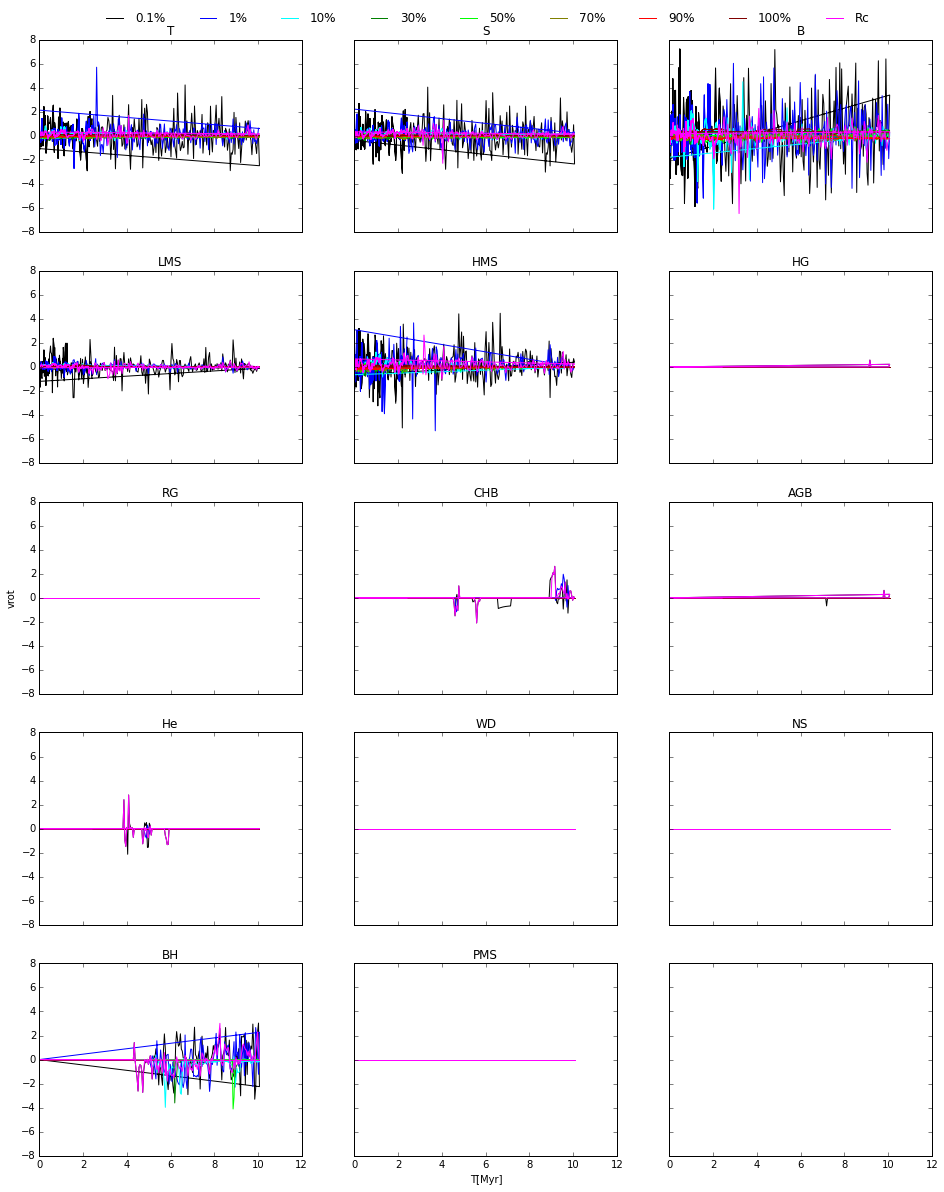

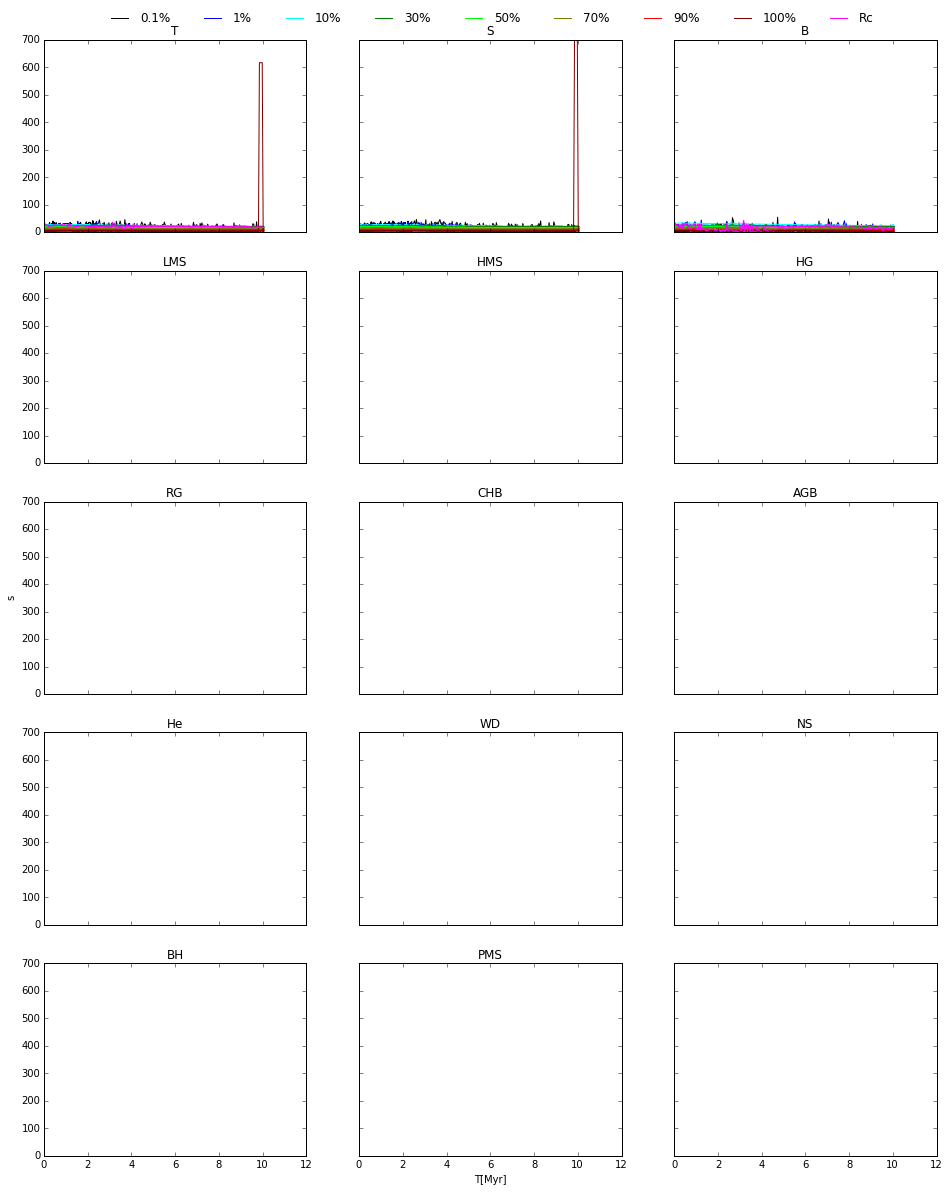

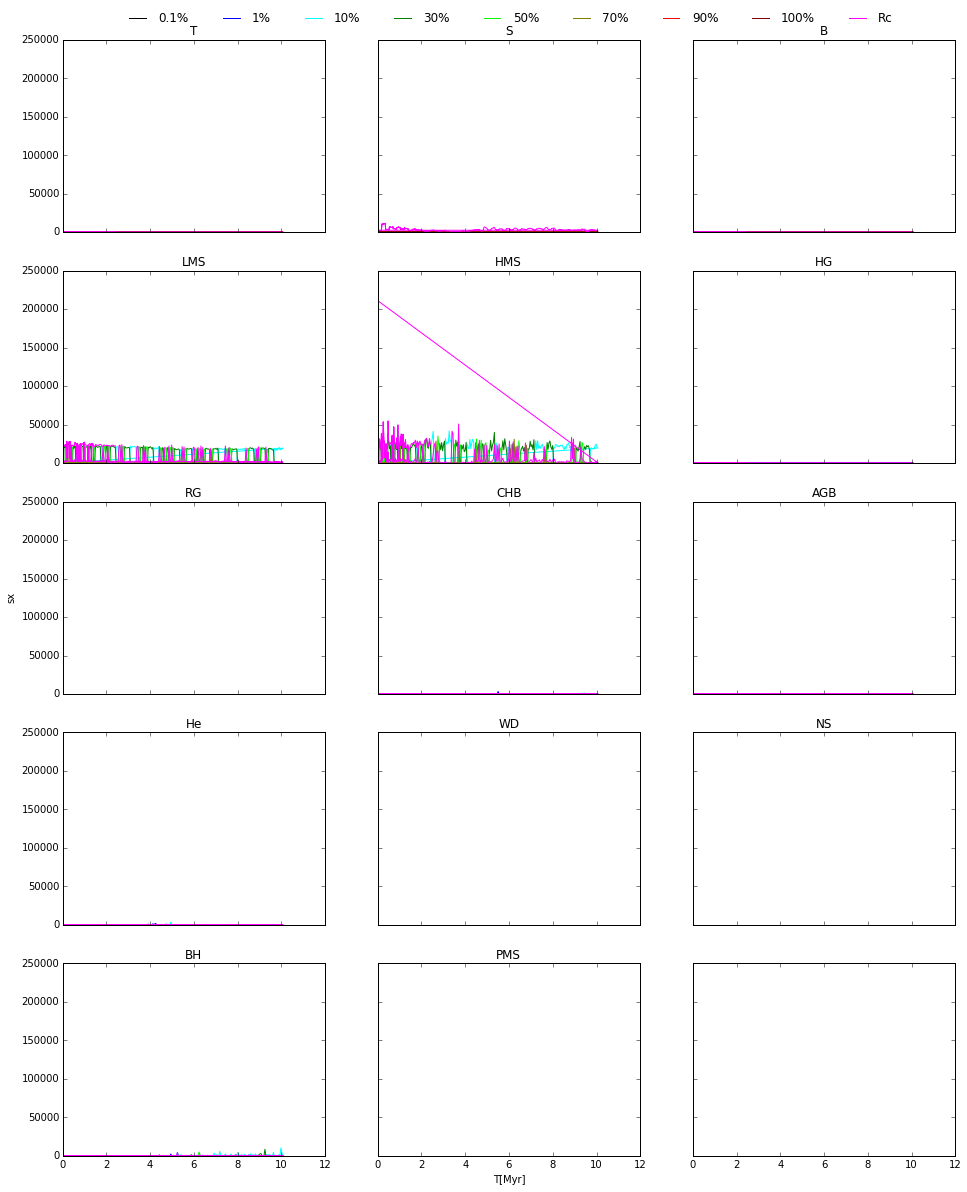

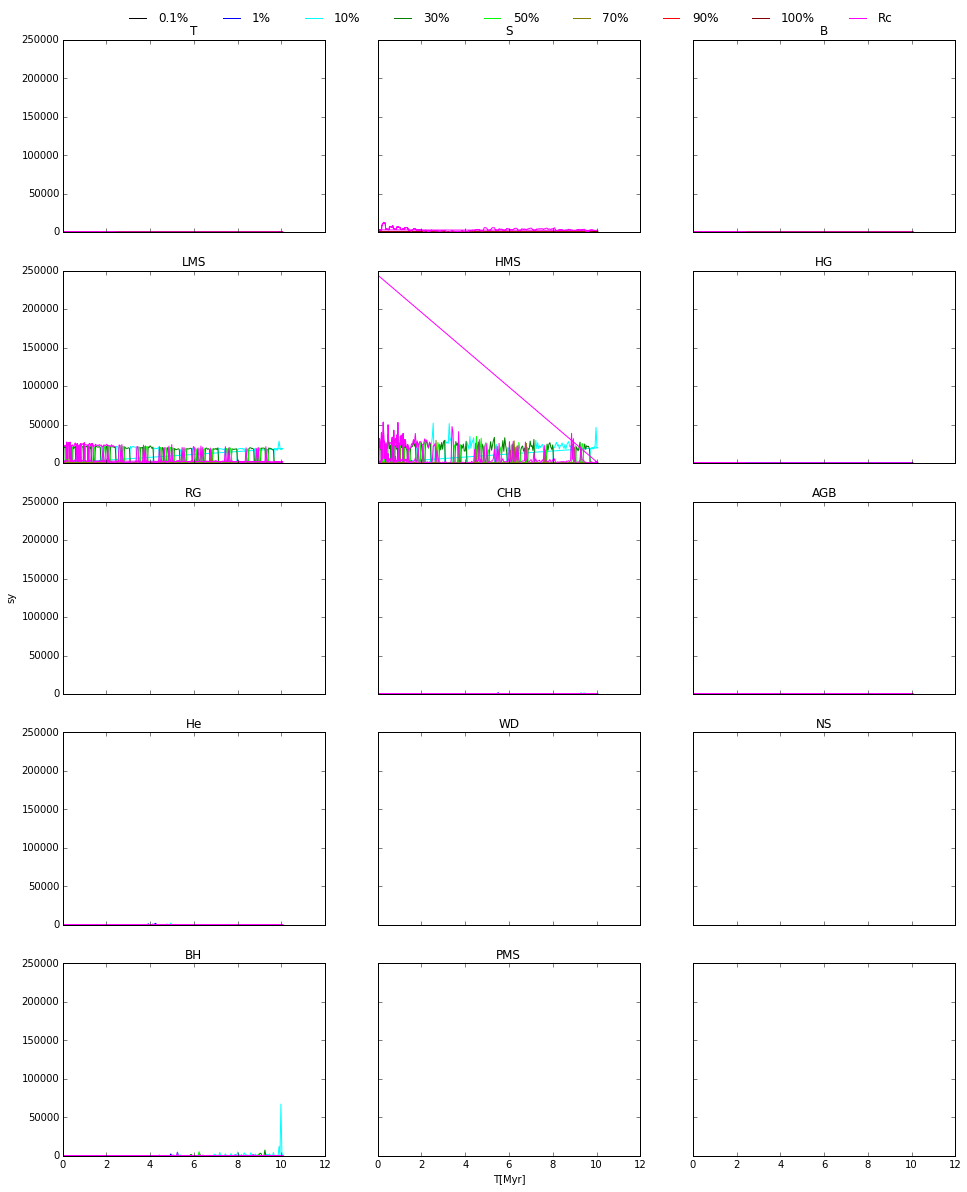

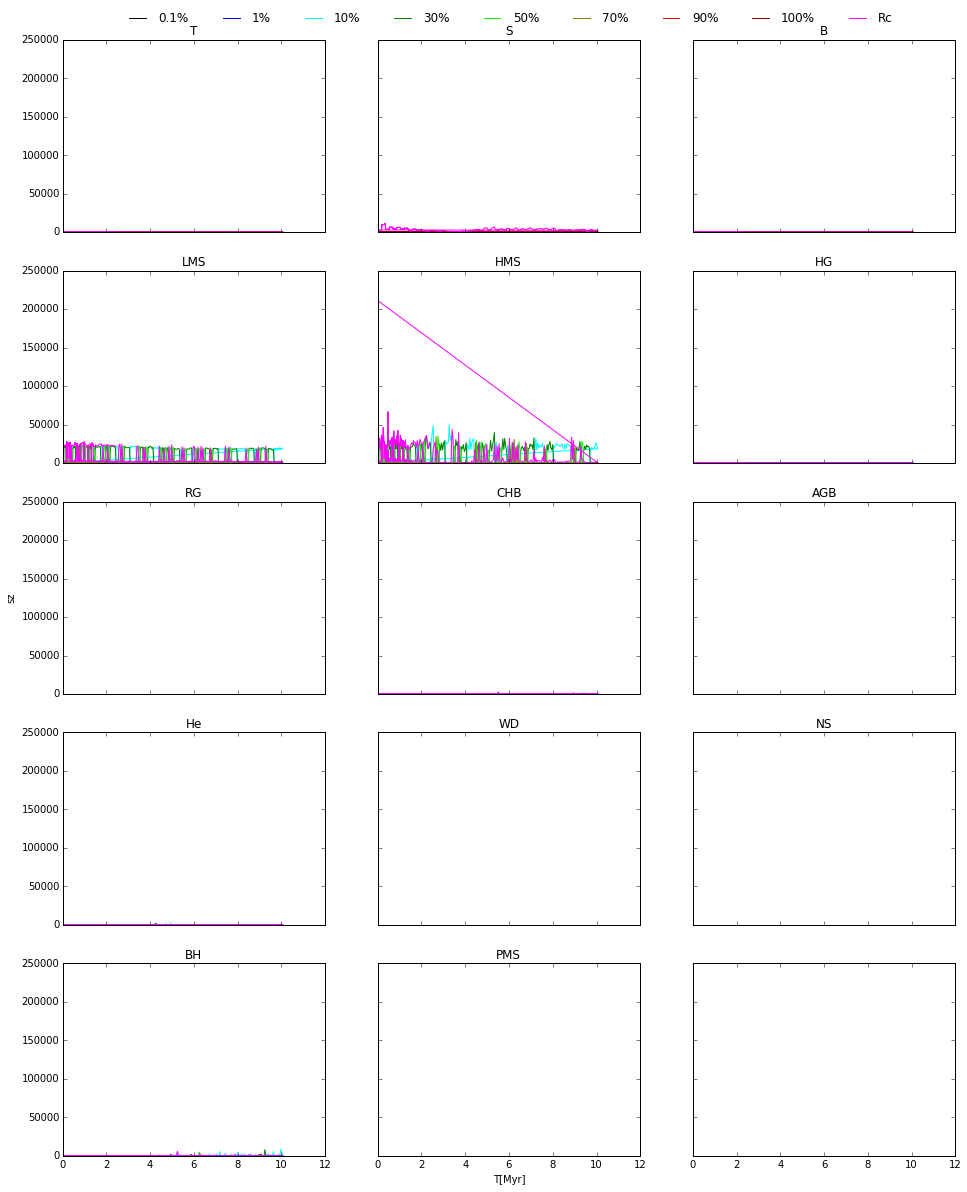

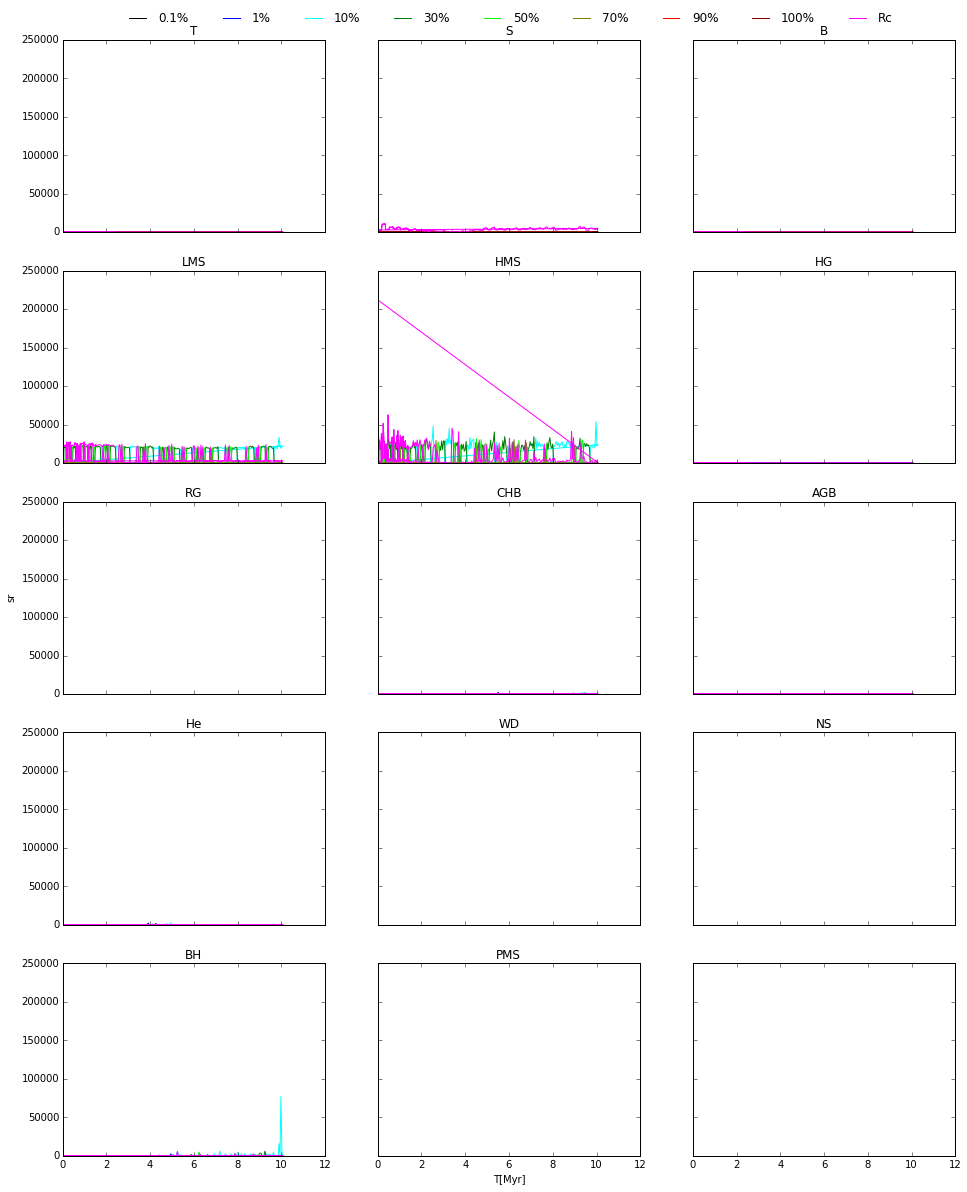

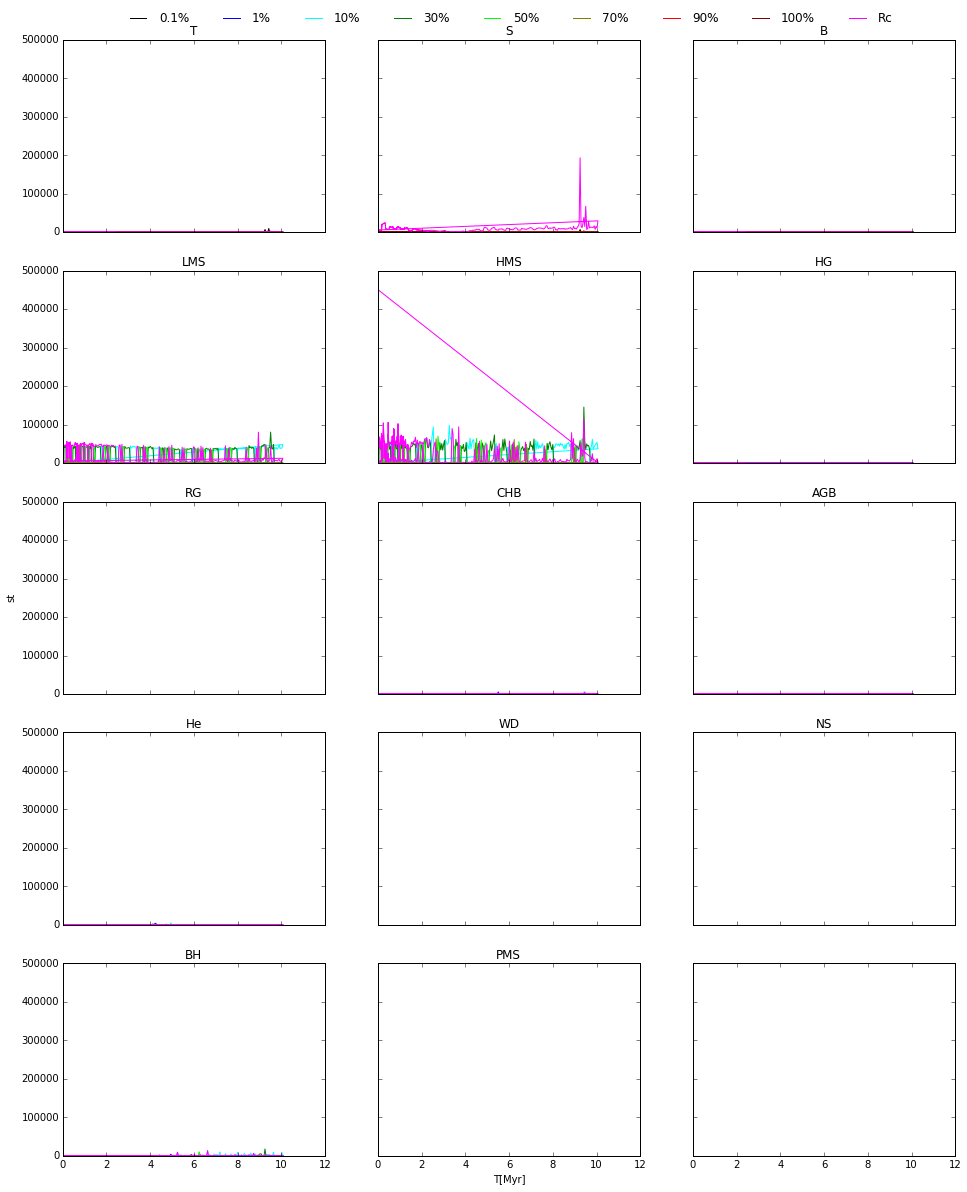

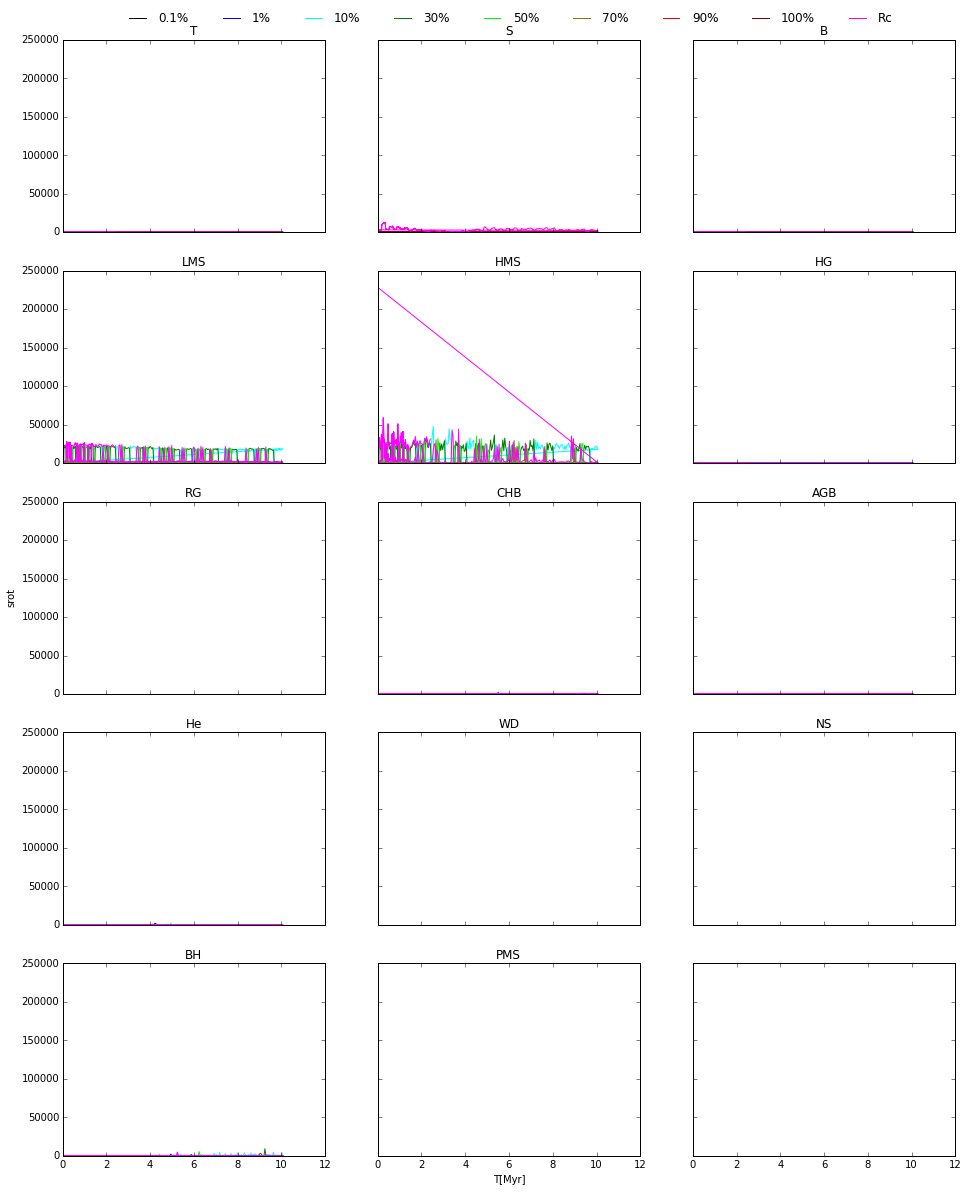

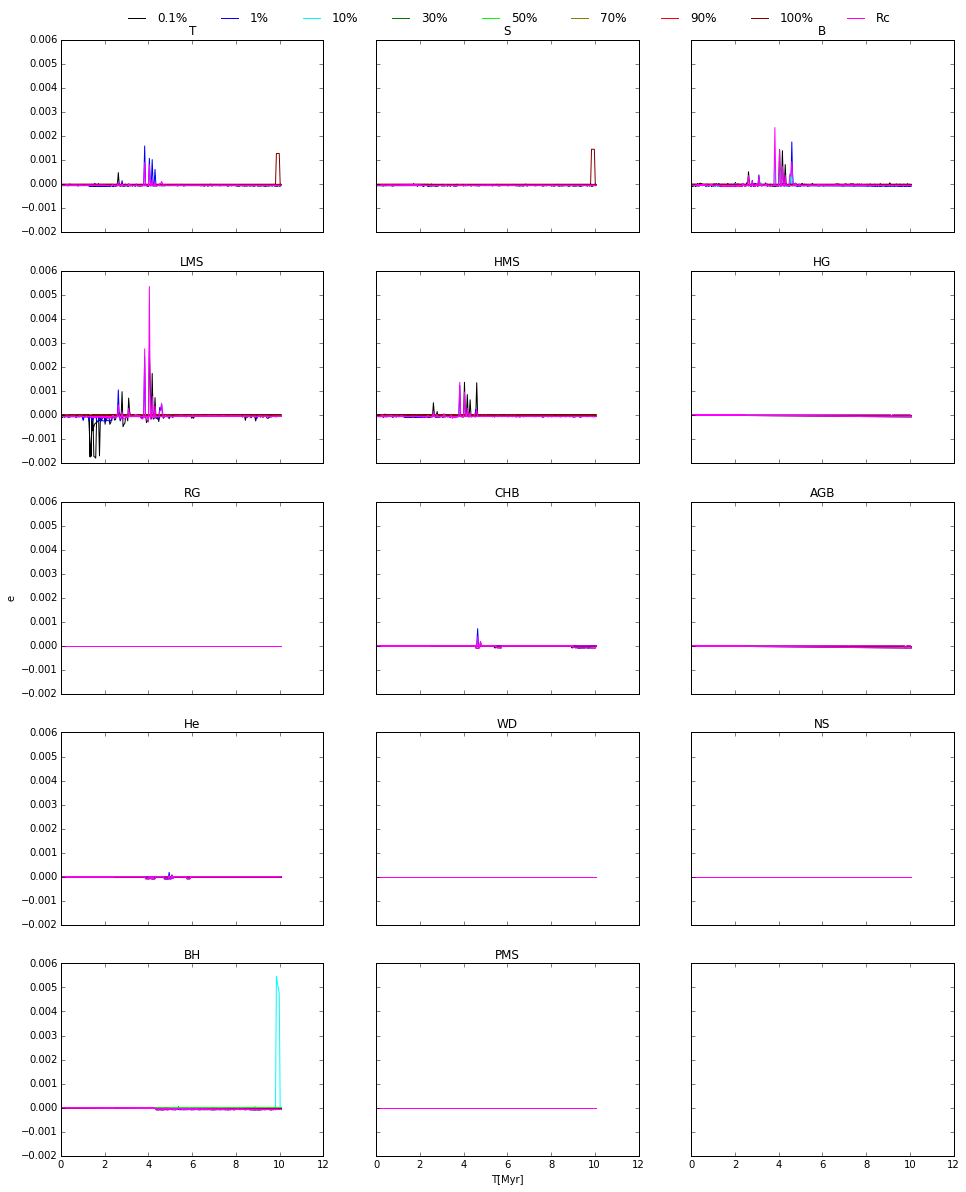

In [13]:
fkeys=data['lagr']['T'].keys()
gkeys=['T','S','B']
skeys=[]
if (fse): skeys=data['lagr']['SE'].keys()

for j in fkeys:
    nrows = 1
    if (fse): nrows = 5 
    fig, axes = plt.subplots(nrows=nrows, ncols=3,sharex=True,sharey=True)
    
    #size of image
    figcf = plt.gcf()
    figcf.set_size_inches(16,20)
    
    if (fse): axes=axes.flatten()
    
    for i in range(3):
        nd = data['lagr'][gkeys[i]][j]
        for k in range(len(nd.keys())):
            key = nd.keys()[k]
            axes[i].plot(data['t']['Myr'],nd[key],'-',color=colors[k],label=key)
        axes[i].set_title(gkeys[i])
    
    if (fse):
        for i in range(len(skeys)):
            nd = data['lagr']['SE'][skeys[i]][j]
            for k in range(len(nd.keys())):
                key = nd.keys()[k]
                axes[i+3].plot(data['t']['Myr'],nd[key],'-',color=colors[k],label=key)
            axes[i+3].set_title(skeys[i])
    axes[nrows*3-2].set_xlabel('T[Myr]')
    axes[nrows/2*3].set_ylabel(j)
    axes[1].legend(mode='expand',bbox_to_anchor=(-1, 1.1, 3.0, .102),ncol=9, frameon=False)
            

## Unused

In [ ]:
#class col_base:
#    def __init__(self,data,names,form):
#        self.data=np.array(zip(*data),dtype={'names':names,'formats':(form,)*len(names)})
#    def __getitem__(self,index):
#        return self.data[index]
    
class col_base:
    def __init__(self,data,names,form):
        self.names=names
        self.data=np.transpose(data).astype(dtype=form)
    def __getitem__(self,index):
        if (type(index) is str):
            return self.data[self.names.index(index)]
        elif (type(index) is int):
            return self.data[index]
        else: 
            raise Exception("Index must be a name or a integer.")
    
class lagr_base:
    def __init__ (self,data,form):
        self.labels=('0.1%','1%','10%','30%','50%','70%','90%','100%','Rc')
        self.ncols=len(self.labels)
        self.data=col_base(self,data,self.labels,form)
    def __getitem__(self,index):
        return self.data[index]
        
class lagr_v_group:
    def __init__(self,data,form):
        ncols=9
        self.v  = lagr_base(data[:,0:ncols],form)
        self.vx = lagr_base(data[:,ncols:2*ncols],form)
        self.vy = lagr_base(data[:,2*ncols:3*ncols],form)
        self.vz = lagr_base(data[:,3*ncols:4*ncols],form)
        self.vr = lagr_base(data[:,4*ncols:5*ncols],form)
        self.vt = lagr_base(data[:,5*ncols:6*ncols],form)
        self.vrot = lagr_base(data[:,6*ncols:7*ncols],form)
        self.labels=self.v.labels
    def __getitem__(self.index):
        if   (index=='v' ) | (index==0): return self.v
        elif (index=='vx') | (index)

class lagr_group:
    def __init__(self,data):
        ncols=9
        self.r = lagr_base(data[:,0:ncols],'f')
        self.n = lagr_base(data[:,ncols:2*ncols],'i')
        self.m = lagr_base(data[:,2*ncols:3*ncols].'f')
        self.vel = lagr_v_group(data[:,3*ncols:10*ncols],'f')
        self.sig = lagr_v_group(data[:,10*ncols,17*ncols],'f')
        self.e = lagr_base(data[:,17*ncols:18*ncols].'f')

class lagr_block:
    def __init__(self,data):
        ncols=162
        self.t = lagr_group(data[:,0:ncols])
        self.s = lagr_group(data[:,ncols:2*ncols])
        self.b = lagr_group(data[:,2*ncols:3*ncols])

class lagr_se_block:
    def __init__(self,data):
        ncols=162
        self.lms = lagr_group(data[:,0:ncols])                 # Low mass main sequence (M < 0.7) (0) 
        self.hms = lagr_group(data[:,ncols:2*ncols])           # High mass main sequence  (1)
        self.hg  = lagr_group(data[:,2*ncols:3*ncols])         # Hertzsprung gap (HG). (2)
        self.rg  = lagr_group(data[:,3*ncols:4*ncols])         # Red giant. (3)
        self.hb  = lagr_group(data[:,4*ncols:5*ncols])         # Core Helium burning. (HB) (4)
        self.agb = lagr_group(data[:,5*ncols:6*ncols])         # AGB (5-6)
        self.he  = lagr_group(data[:,6*ncols:7*ncols])         # Helium types (7-9)
        self.wd  = lagr_group(data[:,7*ncols:8*ncols])         # White dwarf (10-12)
        self.ns  = lagr_group(data[:,8*ncols:9*ncols])         # Neutron star (13)
        self.bh  = lagr_group(data[:,9*ncols:10*ncols])        # Black hole (14)
        self.pms  = lagr_group(data[:,10*ncols:11*ncols])      # Pre main sequence (-1)

        
class status:
    def __init__ (self,path):
        data=np.loadtxt(path)
        ifoff = 16
        self.t = col_base(data[:,0:2],('NB','Myr'),'f')  # Time in NB unit and Myr
        self.tcr = np.array(data[:,2],dtype='f')         # crossing time in Myr
        self.trh = np.array(data[:,3],dtype='f')         # half-mass relaxation time in Myr
        self.mass = col_base(data[:,4:7],('T','S','B'),'f')    # total, single, binary mass in M_sun
        self.q = np.array(data[:,7],dtype='f')           # Virial ration
        self.rh = np.array(data[:,8],dtype='f')          # half-mass radius in pc
        self.rt = np.array(data[:,9],dtype='f')          # tidal radius in pc
        self.rden = col_base(data[:,10:13],('x','y','z'),'f') # Density center position
        self.rhod = np.array(data[:,13],'f')             # Density weighted average density ΣRHO2/ΣRHO 
        self.rhom = np.array(data[:,14],'f')             # Maximum mass density / half mass mean value
        self.mmax = np.array(data[;,15],'f')             # Maxium stellar mass
        ieoff = 12 + ifoff
        self.energy = col_base(data[:,ifoff:ieoff],
                               ('Etot','Ekin','Epot','Ebin','Etid','Em','Ecol','Ece','Ekick','Eesc','Ebesc','Emesc'),
                              'f')                       # Energy parameters
        inoff = 5 + ieoff
        self.n = col_base(data[:,ifoff:inoff],('T','S','B','M','Tu'),'i')  
        # Number of stars Total(resolved),Single,Binary,Triple,Total(unresolved)
        
    def __init__(self,data):
        self.labels=
        self.ncols=len(self.labels)
        self.data=col_base(self,data,self.labels,'f')
    def __getitem__(self,index):
        return self.data[index]
        